# Cotton Candy Data Exploration & Cleaning

This notebook explores the cotton candy dataset to understand data behavior and prepare it for modeling.

**Goal**: Predict quality and process parameters (cook_temp, start_temp, cooled_temp, cook_time) based on environmental conditions (baseline_env_EnvH, baseline_env_EnvT).

**Data cleaning rules**:
- Ignore rows without iteration numbers (corrupted data)
- Focus on environmental conditions and process parameters
- Only save files within DT-2608 folder

In [2]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up paths - try different locations
possible_paths = [
    Path('Data Analysis/Complete_cc_dataset.csv'),  # if running from DT-2608
    Path('../Data Analysis/Complete_cc_dataset.csv'),  # if running from subdirectory
    Path('DT-2608/Data Analysis/Complete_cc_dataset.csv'),  # if running from parent
    Path('./Complete_cc_dataset.csv')  # if file is in same directory
]

csv_path = None
for path in possible_paths:
    if path.exists():
        csv_path = path
        break

if csv_path is None:
    print("Please check the CSV file location. Expected: Complete_cc_dataset.csv")
    print("Current directory:", Path.cwd())
else:
    print(f"Found CSV at: {csv_path}")

# Create output directory
output_dir = Path('cleaned_data')
output_dir.mkdir(exist_ok=True)

Found CSV at: Data Analysis/Complete_cc_dataset.csv


In [3]:
# Load the dataset
print("Loading dataset...")
df = pd.read_csv(csv_path, sep=';', low_memory=False)
print(f"Original dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Display first few rows
df.head()

Loading dataset...
Original dataset shape: (174, 52)
Columns: ['iteration', 'batch_number', 'stick_number', 'index_log', 'stick_weight', 'sugar_amount', 'iteration_since_maintenance', 'wait_time', 'cook_time', 'cooldown_time', 'start_temp', 'cook_temp', 'cooled_temp', 'duration_till_handover', 'duration_total', 'show_start_time', 'show_end_time', 'duration_cc_flow', 'diff_flow', 'diff_flow_stop', 'baseline_env_EnvH', 'baseline_env_EnvT', 'before_turn_on_env_InH', 'before_turn_on_env_InT', 'before_turn_on_env_IrO', 'before_turn_on_env_IrA', 'after_flow_start_env_InH', 'after_flow_start_env_InT', 'after_flow_start_env_IrO', 'after_flow_start_env_IrA', 'after_flow_end_env_InH', 'after_flow_end_env_InT', 'after_flow_end_env_IrO', 'after_flow_end_env_IrA', 'before_cooldown_env_InH', 'before_cooldown_env_InT', 'before_cooldown_env_IrO', 'before_cooldown_env_IrA', 'after_cooldown_env_InH', 'after_cooldown_env_InT', 'after_cooldown_env_IrO', 'after_cooldown_env_IrA', 'touch_pos1', 'touch_pos2'

,iteration,batch_number,stick_number,index_log,stick_weight,sugar_amount,iteration_since_maintenance,wait_time,cook_time,cooldown_time,...,touch_pos1,touch_pos2,touch_pos3,max_pos1,max_pos2,max_pos3,cc_weight,quality_score,my_score,Unnamed: 51
0,0.0,0.0,0.0,61169.0,1.8,1.0,52.0,102.0,105.0,60.0,...,2.0,2.0,3.0,30.80,0.00,21.91,10.02,NaN,60,NaN
1,1.0,0.0,1.0,61177.0,1.8,1.0,53.0,102.0,105.0,60.0,...,4.0,1.0,3.0,23.54,7.08,2.46,8.48,NaN,15,NaN
2,2.0,0.0,2.0,61184.0,1.8,1.0,54.0,102.0,105.0,60.0,...,1.0,4.0,3.0,27.52,0.00,22.54,8.19,NaN,10,NaN
3,3.0,0.0,3.0,61191.0,1.8,1.0,55.0,102.0,105.0,60.0,...,5.0,4.0,6.0,32.47,30.77,19.16,8.20,NaN,8,NaN
4,4.0,1.0,0.0,61233.0,1.8,1.0,0.0,102.0,105.0,60.0,...,1.0,3.0,1.0,34.85,2.58,13.55,9.99,NaN,80,NaN


In [4]:
# Basic data inspection
print("=== BASIC DATA INFO ===")
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n=== MISSING VALUES ===")
missing_data = df.isnull().sum()
print(f"Columns with missing values: {missing_data[missing_data > 0].shape[0]}")
if missing_data[missing_data > 0].shape[0] > 0:
    print("\nTop columns with missing values:")
    print(missing_data[missing_data > 0].sort_values(ascending=False).head(10))

print("\n=== DATA TYPES ===")
print(df.dtypes.value_counts())

=== BASIC DATA INFO ===
Dataset shape: (174, 52)
Memory usage: 0.09 MB

=== MISSING VALUES ===
Columns with missing values: 49

Top columns with missing values:
Unnamed: 51                174
diff_flow                  124
diff_flow_stop             124
quality_score               55
before_cooldown_env_IrA     45
before_cooldown_env_IrO     45
before_cooldown_env_InT     45
before_cooldown_env_InH     45
cc_weight                   41
after_flow_end_env_IrA      25
dtype: int64

=== DATA TYPES ===
float64    49
object      3
Name: count, dtype: int64


In [14]:
# Rule 1: Remove rows without iteration numbers (corrupted data) AND without cc_weight (missing target)
print("=== CLEANING STEP 1: Remove corrupted data and missing weights ===")
print(f"Rows before cleaning: {len(df)}")

# Check iteration column
print(f"Iteration column type: {df['iteration'].dtype}")
print(f"Unique iteration values (first 20): {df['iteration'].unique()[:20]}")

# Convert iteration to numeric, invalid entries become NaN
df['iteration_numeric'] = pd.to_numeric(df['iteration'], errors='coerce')

# Count rows with valid iteration numbers
valid_iterations = df['iteration_numeric'].notna()
print(f"Rows with valid iteration numbers: {valid_iterations.sum()}")
print(f"Rows without valid iteration numbers (corrupted): {(~valid_iterations).sum()}")

# Check cc_weight column
print(f"\ncc_weight column type: {df['cc_weight'].dtype}")

# Convert cc_weight to numeric, invalid entries become NaN
df['cc_weight_numeric'] = pd.to_numeric(df['cc_weight'], errors='coerce')

# Count rows with valid weight values
valid_weights = df['cc_weight_numeric'].notna()
print(f"Rows with valid cc_weight values: {valid_weights.sum()}")
print(f"Rows without valid cc_weight (missing target): {(~valid_weights).sum()}")

# Remove rows missing EITHER iteration OR cc_weight
valid_rows = valid_iterations & valid_weights
print(f"\nRows with BOTH valid iteration AND cc_weight: {valid_rows.sum()}")
print(f"Rows missing iteration OR cc_weight: {(~valid_rows).sum()}")
print(f"Percentage of data retained: {(valid_rows.sum() / len(df)) * 100:.1f}%")

# Remove rows missing EITHER iteration OR cc_weight
df_clean = df[valid_rows].copy()
print(f"Rows after removing corrupted data and missing weights: {len(df_clean)}")

# Use the numeric columns
df_clean['iteration'] = df_clean['iteration_numeric']
df_clean['cc_weight'] = df_clean['cc_weight_numeric']
df_clean = df_clean.drop(['iteration_numeric', 'cc_weight_numeric'], axis=1)

=== CLEANING STEP 1: Remove corrupted data and missing weights ===
Rows before cleaning: 174
Iteration column type: float64
Unique iteration values (first 20): [ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan 10. 11. 12. 13. 14. 16. 17. 18.
 19. 20.]
Rows with valid iteration numbers: 161
Rows without valid iteration numbers (corrupted): 13

cc_weight column type: float64
Rows with valid cc_weight values: 133
Rows without valid cc_weight (missing target): 41

Rows with BOTH valid iteration AND cc_weight: 131
Rows missing iteration OR cc_weight: 43
Percentage of data retained: 75.3%
Rows after removing corrupted data and missing weights: 131


In [15]:
# Focus on key columns for our analysis (removing iteration as it's just a row identifier)
key_columns = [
    'iteration_since_maintenance',
    'baseline_env_EnvH',  # Environmental humidity - INPUT FEATURE
    'baseline_env_EnvT',  # Environmental temperature - INPUT FEATURE
    'cook_temp',          # Target: Cooking temperature
    'start_temp',         # Target: Starting temperature  
    'cooled_temp',        # Target: Cooling temperature
    'cook_time',          # Target: Cooking time
    'cc_weight',          # Target: Weight of cotton candy
    #'quality_score',      # Target: Quality prediction
    #'my_score'            # Alternative quality score
]

print("=== FOCUSING ON KEY COLUMNS ===")
available_columns = [col for col in key_columns if col in df_clean.columns]
missing_columns = [col for col in key_columns if col not in df_clean.columns]

print(f"Available columns: {available_columns}")
if missing_columns:
    print(f"Missing columns: {missing_columns}")

# Create focused dataset
df_focused = df_clean[available_columns].copy()
print(f"Focused dataset shape: {df_focused.shape}")

# Display summary
df_focused.describe()

=== FOCUSING ON KEY COLUMNS ===
Available columns: ['iteration_since_maintenance', 'baseline_env_EnvH', 'baseline_env_EnvT', 'cook_temp', 'start_temp', 'cooled_temp', 'cook_time', 'cc_weight']
Focused dataset shape: (131, 8)


,iteration_since_maintenance,baseline_env_EnvH,baseline_env_EnvT,cook_temp,start_temp,cooled_temp,cook_time,cc_weight
count,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000
mean,25.702290,59.760534,24.129924,57.205954,54.968702,61.468702,69.389313,8.228015
std,14.058501,8.020734,1.691216,10.149863,11.492008,7.658312,19.024103,1.794386
min,0.000000,41.230000,19.920000,23.650000,21.850000,52.000000,0.000000,0.000000
25%,15.000000,57.320000,22.850000,53.000000,50.000000,55.430000,61.000000,7.840000
50%,25.000000,61.980000,24.140000,58.370000,55.450000,60.030000,72.000000,8.500000
75%,35.500000,65.730000,25.770000,61.520000,61.100000,65.490000,80.000000,9.105000
max,55.000000,70.270000,26.290000,74.270000,76.570000,82.450000,105.000000,12.180000


In [16]:
# Data type conversion and cleaning
print("=== CLEANING STEP 2: Data type conversion ===")

# Convert environmental and process parameters to numeric
numeric_columns = ['baseline_env_EnvH', 'baseline_env_EnvT', 'cook_temp', 
                  'start_temp', 'cooled_temp', 'cook_time', 'cc_weight']

for col in numeric_columns:
    if col in df_focused.columns:
        original_type = df_focused[col].dtype
        df_focused[col] = pd.to_numeric(df_focused[col], errors='coerce')
        converted_type = df_focused[col].dtype
        print(f"{col}: {original_type} -> {converted_type}")

# Check for missing values after conversion
print("\n=== MISSING VALUES AFTER CONVERSION ===")
missing_after = df_focused.isnull().sum()
for col in missing_after[missing_after > 0].index:
    pct_missing = (missing_after[col] / len(df_focused)) * 100
    print(f"{col}: {missing_after[col]} missing ({pct_missing:.1f}%)")

df_focused.head()

=== CLEANING STEP 2: Data type conversion ===
baseline_env_EnvH: float64 -> float64
baseline_env_EnvT: float64 -> float64
cook_temp: float64 -> float64
start_temp: float64 -> float64
cooled_temp: float64 -> float64
cook_time: float64 -> float64
cc_weight: float64 -> float64

=== MISSING VALUES AFTER CONVERSION ===


,iteration_since_maintenance,baseline_env_EnvH,baseline_env_EnvT,cook_temp,start_temp,cooled_temp,cook_time,cc_weight
0,52.0,63.73,24.59,31.75,25.49,62.03,105.0,10.02
1,53.0,62.78,24.65,60.63,58.89,64.65,105.0,8.48
2,54.0,62.49,24.72,62.47,61.85,61.63,105.0,8.19
3,55.0,62.44,24.72,60.55,58.63,76.97,105.0,8.20
4,0.0,60.44,23.63,31.05,25.41,60.03,105.0,9.99


In [18]:
# Create final cleaned dataset
print("=== CREATING FINAL CLEANED DATASET ===")

# target
target_columns = ['cc_weight']
available_targets = [col for col in target_columns if col in df_focused.columns]

# our input features
required_columns = ['cook_temp', 'start_temp', 'cooled_temp', 'cook_time', 'baseline_env_EnvH', 'baseline_env_EnvT']
available_required = [col for col in required_columns if col in df_focused.columns]

print(f"Input features (required): {available_required}")
print(f"Target columns available: {available_targets}")

# Create final dataset with complete environmental data
final_df = df_focused[df_focused[available_required].notna().all(axis=1)].copy()
print(f"Rows with complete environmental data: {len(final_df)}")

# Add a completeness score for each row (percentage of target columns with data)
if available_targets:
    final_df['data_completeness'] = final_df[available_targets].notna().mean(axis=1)
    print(f"Average data completeness: {final_df['data_completeness'].mean():.2%}")

# Save the cleaned dataset
output_file = output_dir / 'cleaned_cotton_candy_data.csv'
final_df.to_csv(output_file, index=False)
print(f"Cleaned dataset saved to: {output_file}")

# Final summary
print(f"\n=== FINAL DATASET SUMMARY ===")
print(f"Original rows: {df.shape[0]}")
print(f"After removing corrupted data: {len(df_clean)}")
print(f"Final cleaned rows: {len(final_df)}")
print(f"Data retention rate: {(len(final_df) / df.shape[0]) * 100:.1f}%")

final_df.head(10)

=== CREATING FINAL CLEANED DATASET ===
Input features (required): ['cook_temp', 'start_temp', 'cooled_temp', 'cook_time', 'baseline_env_EnvH', 'baseline_env_EnvT']
Target columns available: ['cc_weight']
Rows with complete environmental data: 131
Average data completeness: 100.00%
Cleaned dataset saved to: cleaned_data/cleaned_cotton_candy_data.csv

=== FINAL DATASET SUMMARY ===
Original rows: 174
After removing corrupted data: 131
Final cleaned rows: 131
Data retention rate: 75.3%


,iteration_since_maintenance,baseline_env_EnvH,baseline_env_EnvT,cook_temp,start_temp,cooled_temp,cook_time,cc_weight,data_completeness
0,52.0,63.73,24.59,31.75,25.49,62.03,105.0,10.02,1.0
1,53.0,62.78,24.65,60.63,58.89,64.65,105.0,8.48,1.0
2,54.0,62.49,24.72,62.47,61.85,61.63,105.0,8.19,1.0
3,55.0,62.44,24.72,60.55,58.63,76.97,105.0,8.20,1.0
4,0.0,60.44,23.63,31.05,25.41,60.03,105.0,9.99,1.0
5,1.0,60.35,23.80,58.51,59.27,62.61,95.0,9.00,1.0
6,2.0,60.13,24.00,59.93,59.85,64.11,75.0,9.04,1.0
7,3.0,60.18,24.08,61.75,60.25,63.67,45.0,9.59,1.0
8,4.0,60.22,24.14,61.53,60.31,59.09,5.0,7.17,1.0
10,6.0,60.41,24.29,33.39,27.61,60.75,105.0,12.18,1.0


In [19]:
# ===== EXPLORATORY DATA ANALYSIS =====
print("=== EXPLORATORY DATA ANALYSIS ===")
print("Now let's explore patterns and relationships in the clean data!")

# Load the cleaned dataset
clean_df = pd.read_csv(output_dir / 'cleaned_cotton_candy_data.csv')
print(f"Clean dataset shape: {clean_df.shape}")

# Separate input features and targets
input_features = ['baseline_env_EnvH', 'baseline_env_EnvT']
process_targets = ['cook_temp', 'start_temp', 'cooled_temp', 'cook_time']
weight_target = ['cc_weight']

print(f"Input features: {input_features}")
print(f"Process targets: {process_targets}")
print(f"Weight target: {weight_target}")

clean_df.head()

=== EXPLORATORY DATA ANALYSIS ===
Now let's explore patterns and relationships in the clean data!
Clean dataset shape: (131, 9)
Input features: ['baseline_env_EnvH', 'baseline_env_EnvT']
Process targets: ['cook_temp', 'start_temp', 'cooled_temp', 'cook_time']
Weight target: ['cc_weight']


,iteration_since_maintenance,baseline_env_EnvH,baseline_env_EnvT,cook_temp,start_temp,cooled_temp,cook_time,cc_weight,data_completeness
0,52.0,63.73,24.59,31.75,25.49,62.03,105.0,10.02,1.0
1,53.0,62.78,24.65,60.63,58.89,64.65,105.0,8.48,1.0
2,54.0,62.49,24.72,62.47,61.85,61.63,105.0,8.19,1.0
3,55.0,62.44,24.72,60.55,58.63,76.97,105.0,8.20,1.0
4,0.0,60.44,23.63,31.05,25.41,60.03,105.0,9.99,1.0


In [20]:
# 1. STATISTICAL SUMMARY OF ALL VARIABLES
print("=== 1. STATISTICAL SUMMARY ===")
print("\n📊 Input Features (Environmental Conditions):")
print(clean_df[input_features].describe())

print("\n🎛️ Process Parameters:")
print(clean_df[process_targets].describe())

print("\n⚖️ Cotton Candy Weight:")
print(clean_df[weight_target].describe())

# Check ranges and identify any outliers
print("\n=== RANGES AND POTENTIAL OUTLIERS ===")
for col in clean_df.select_dtypes(include=[np.number]).columns:
    if col != 'iteration':  # Skip iteration since we'll remove it
        Q1 = clean_df[col].quantile(0.25)
        Q3 = clean_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((clean_df[col] < lower_bound) | (clean_df[col] > upper_bound)).sum()
        print(f"{col}: Range [{clean_df[col].min():.2f}, {clean_df[col].max():.2f}], Outliers: {outliers}")

=== 1. STATISTICAL SUMMARY ===

📊 Input Features (Environmental Conditions):
       baseline_env_EnvH  baseline_env_EnvT
count         131.000000         131.000000
mean           59.760534          24.129924
std             8.020734           1.691216
min            41.230000          19.920000
25%            57.320000          22.850000
50%            61.980000          24.140000
75%            65.730000          25.770000
max            70.270000          26.290000

🎛️ Process Parameters:
        cook_temp  start_temp  cooled_temp   cook_time
count  131.000000  131.000000   131.000000  131.000000
mean    57.205954   54.968702    61.468702   69.389313
std     10.149863   11.492008     7.658312   19.024103
min     23.650000   21.850000    52.000000    0.000000
25%     53.000000   50.000000    55.430000   61.000000
50%     58.370000   55.450000    60.030000   72.000000
75%     61.520000   61.100000    65.490000   80.000000
max     74.270000   76.570000    82.450000  105.000000

⚖️ Cott

=== 2. CORRELATION ANALYSIS ===


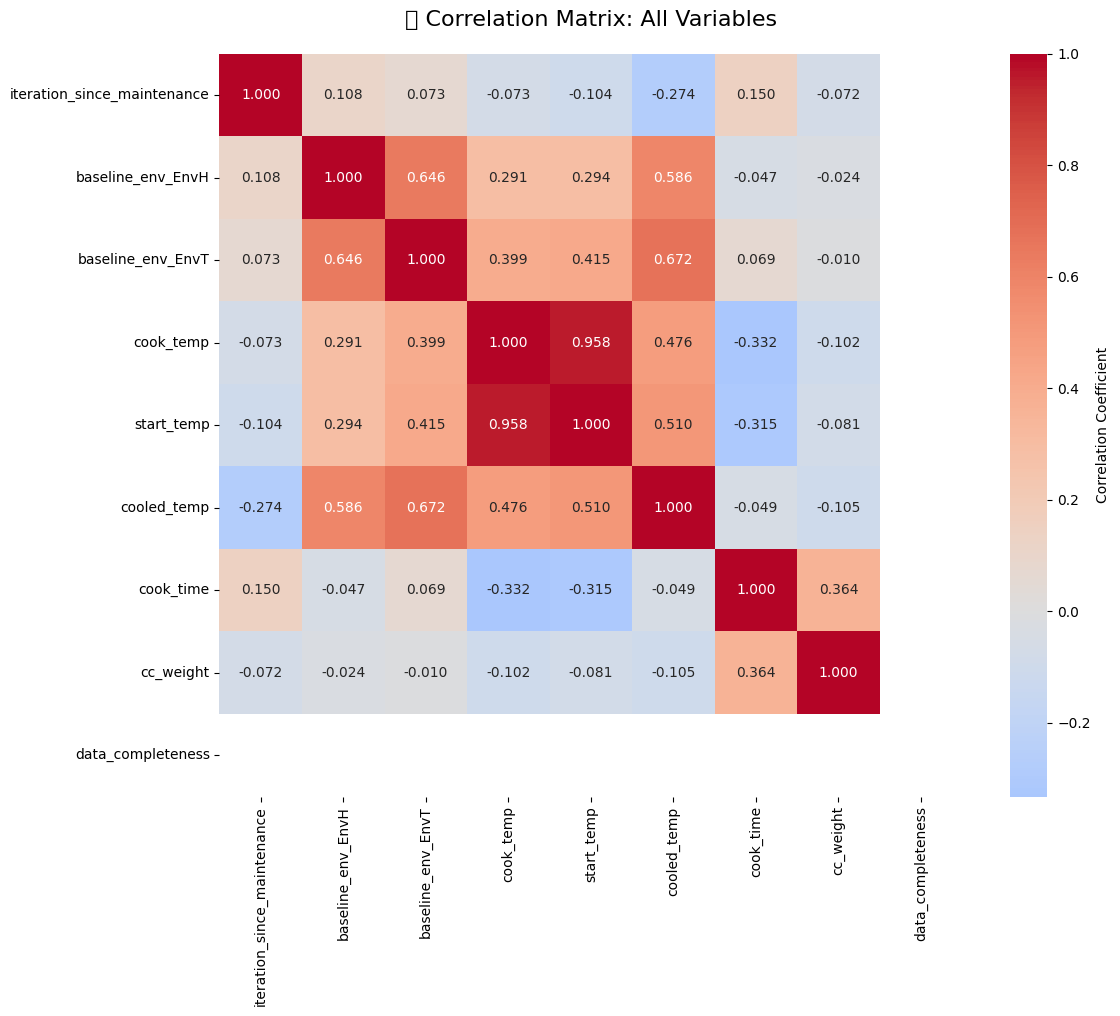


⚖️ COTTON CANDY WEIGHT CORRELATIONS:
cook_time: 0.364 (🟡 Moderate)
baseline_env_EnvT: -0.010 (⚪ Weak)
baseline_env_EnvH: -0.024 (⚪ Weak)
iteration_since_maintenance: -0.072 (⚪ Weak)
start_temp: -0.081 (⚪ Weak)
cook_temp: -0.102 (⚪ Weak)
cooled_temp: -0.105 (⚪ Weak)
data_completeness: nan (⚪ Weak)

🌡️ ENVIRONMENTAL CONDITIONS CORRELATIONS:
                   baseline_env_EnvH  baseline_env_EnvT
baseline_env_EnvH           1.000000           0.645565
baseline_env_EnvT           0.645565           1.000000


In [21]:
# 2. CORRELATION ANALYSIS
print("=== 2. CORRELATION ANALYSIS ===")

# Select numeric columns (excluding iteration)
numeric_cols = [col for col in clean_df.select_dtypes(include=[np.number]).columns if col != 'iteration']
correlation_matrix = clean_df[numeric_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('🔥 Correlation Matrix: All Variables', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig(output_dir / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Key correlations with cotton candy weight
print("\n⚖️ COTTON CANDY WEIGHT CORRELATIONS:")
weight_corr = correlation_matrix['cc_weight'].sort_values(ascending=False)
for var, corr in weight_corr.items():
    if var != 'cc_weight':
        strength = "🔴 Strong" if abs(corr) > 0.7 else "🟡 Moderate" if abs(corr) > 0.3 else "⚪ Weak"
        print(f"{var}: {corr:.3f} ({strength})")

# Environmental conditions correlations
print("\n🌡️ ENVIRONMENTAL CONDITIONS CORRELATIONS:")
env_corr = correlation_matrix.loc[input_features, input_features]
print(env_corr)

=== 3. ENVIRONMENTAL CONDITIONS vs TARGETS ===


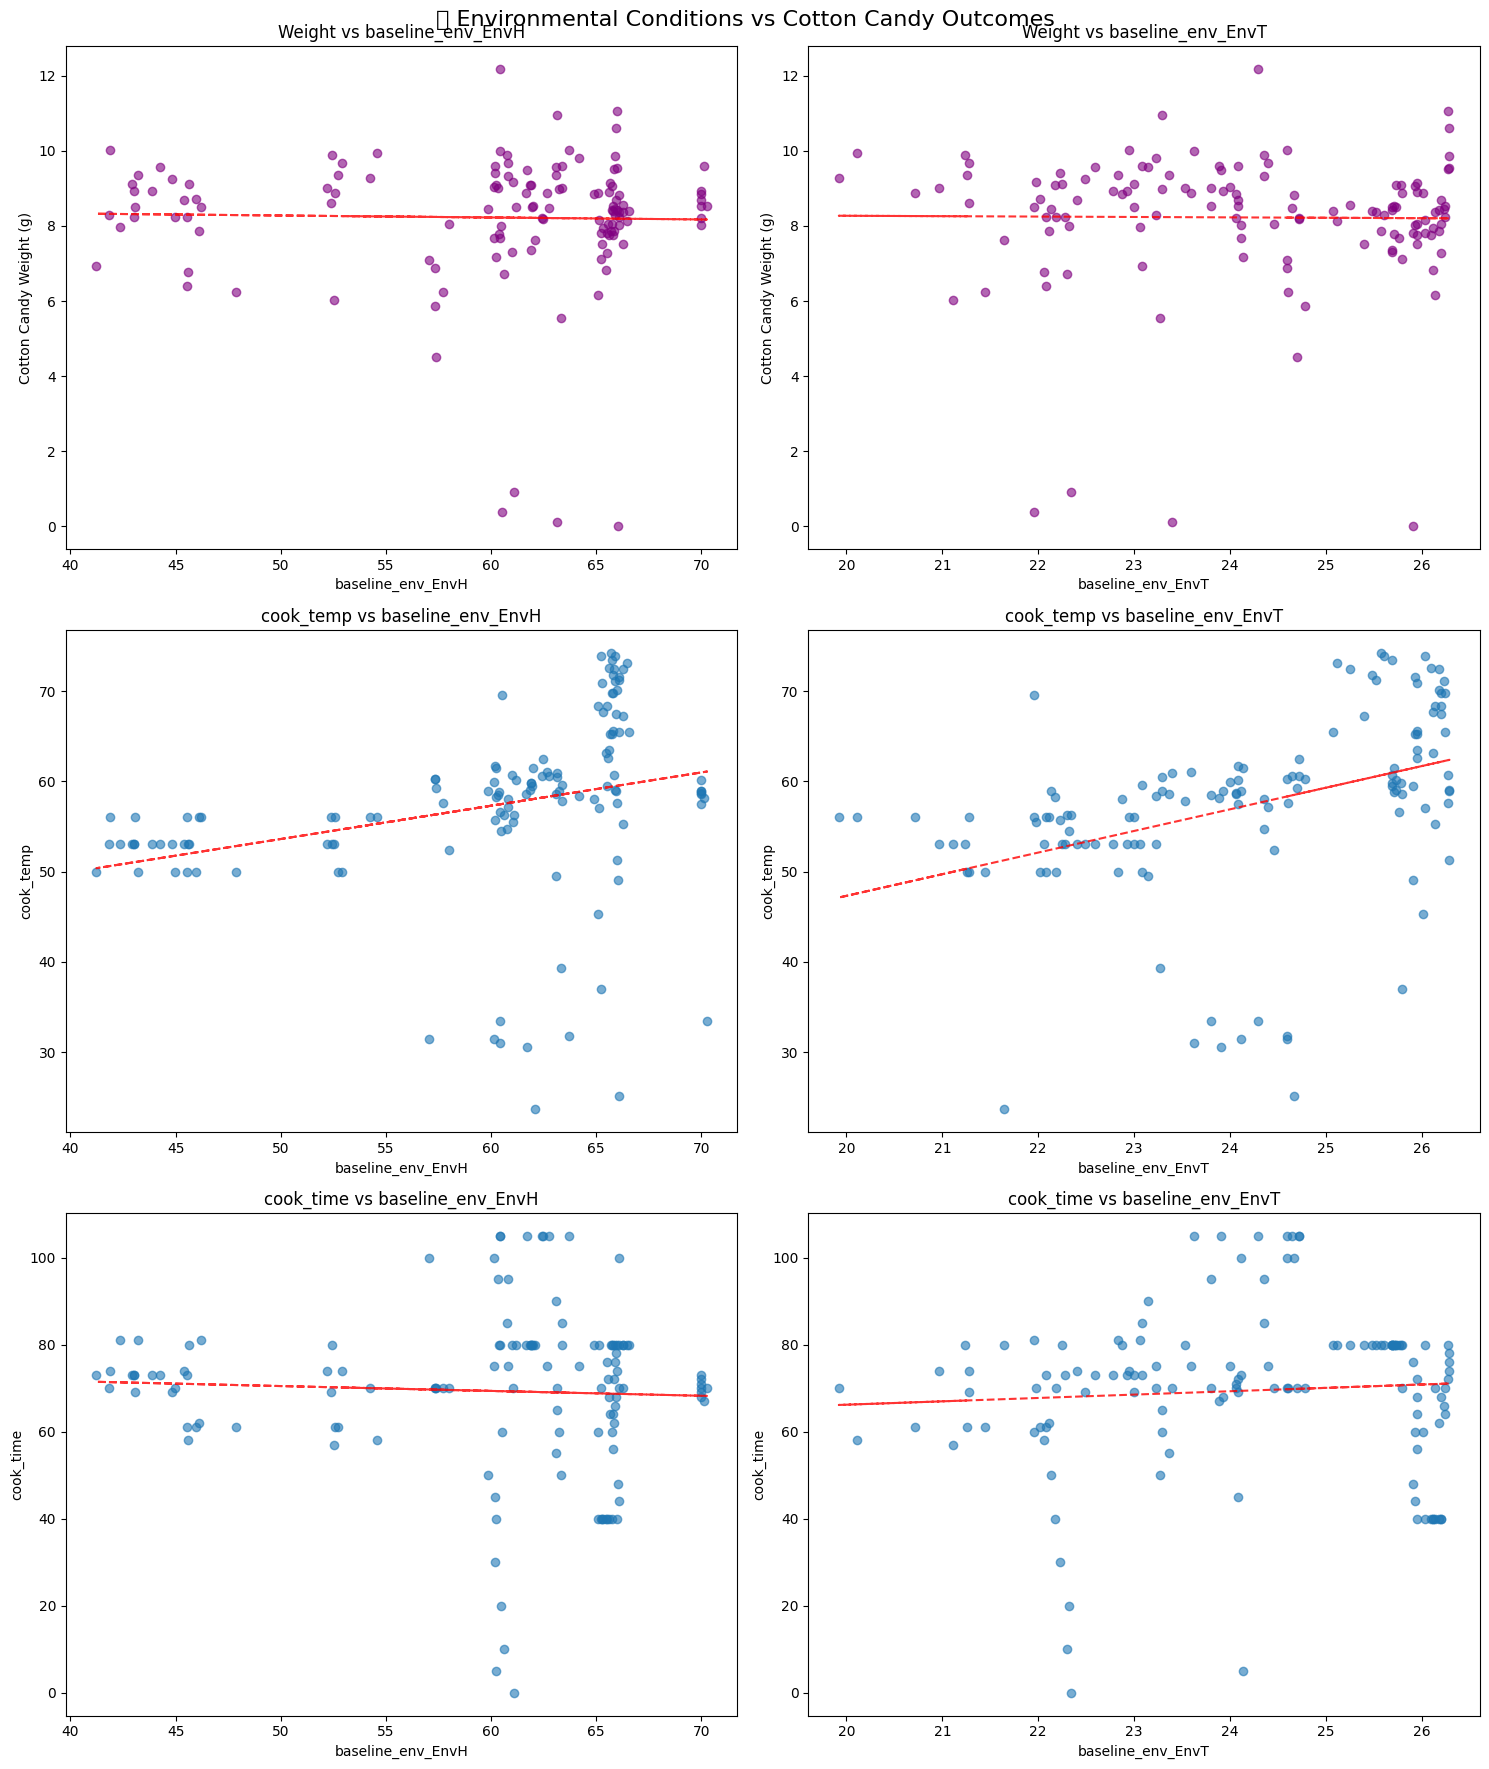

In [22]:
# 3. ENVIRONMENTAL CONDITIONS vs TARGETS
print("=== 3. ENVIRONMENTAL CONDITIONS vs TARGETS ===")

# Create scatter plots: Environment → Targets
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('🌡️ Environmental Conditions vs Cotton Candy Outcomes', fontsize=16)

# Plot environmental conditions vs weight
for i, env_var in enumerate(input_features):
    # Weight vs environmental condition
    axes[0, i].scatter(clean_df[env_var], clean_df['cc_weight'], alpha=0.6, color='purple')
    axes[0, i].set_xlabel(f'{env_var}')
    axes[0, i].set_ylabel('Cotton Candy Weight (g)')
    axes[0, i].set_title(f'Weight vs {env_var}')
    
    # Add trendline
    z = np.polyfit(clean_df[env_var], clean_df['cc_weight'], 1)
    p = np.poly1d(z)
    axes[0, i].plot(clean_df[env_var], p(clean_df[env_var]), "r--", alpha=0.8)

# Plot environmental conditions vs key process parameters
key_process = ['cook_temp', 'cook_time']  # Most important process parameters
for i, env_var in enumerate(input_features):
    for j, process_var in enumerate(key_process):
        row_idx = j + 1
        axes[row_idx, i].scatter(clean_df[env_var], clean_df[process_var], alpha=0.6)
        axes[row_idx, i].set_xlabel(f'{env_var}')
        axes[row_idx, i].set_ylabel(f'{process_var}')
        axes[row_idx, i].set_title(f'{process_var} vs {env_var}')
        
        # Add trendline
        z = np.polyfit(clean_df[env_var], clean_df[process_var], 1)
        p = np.poly1d(z)
        axes[row_idx, i].plot(clean_df[env_var], p(clean_df[env_var]), "r--", alpha=0.8)

plt.tight_layout()
plt.savefig(output_dir / 'environment_vs_targets.png', dpi=300, bbox_inches='tight')
plt.show()

=== 4. DISTRIBUTION ANALYSIS ===


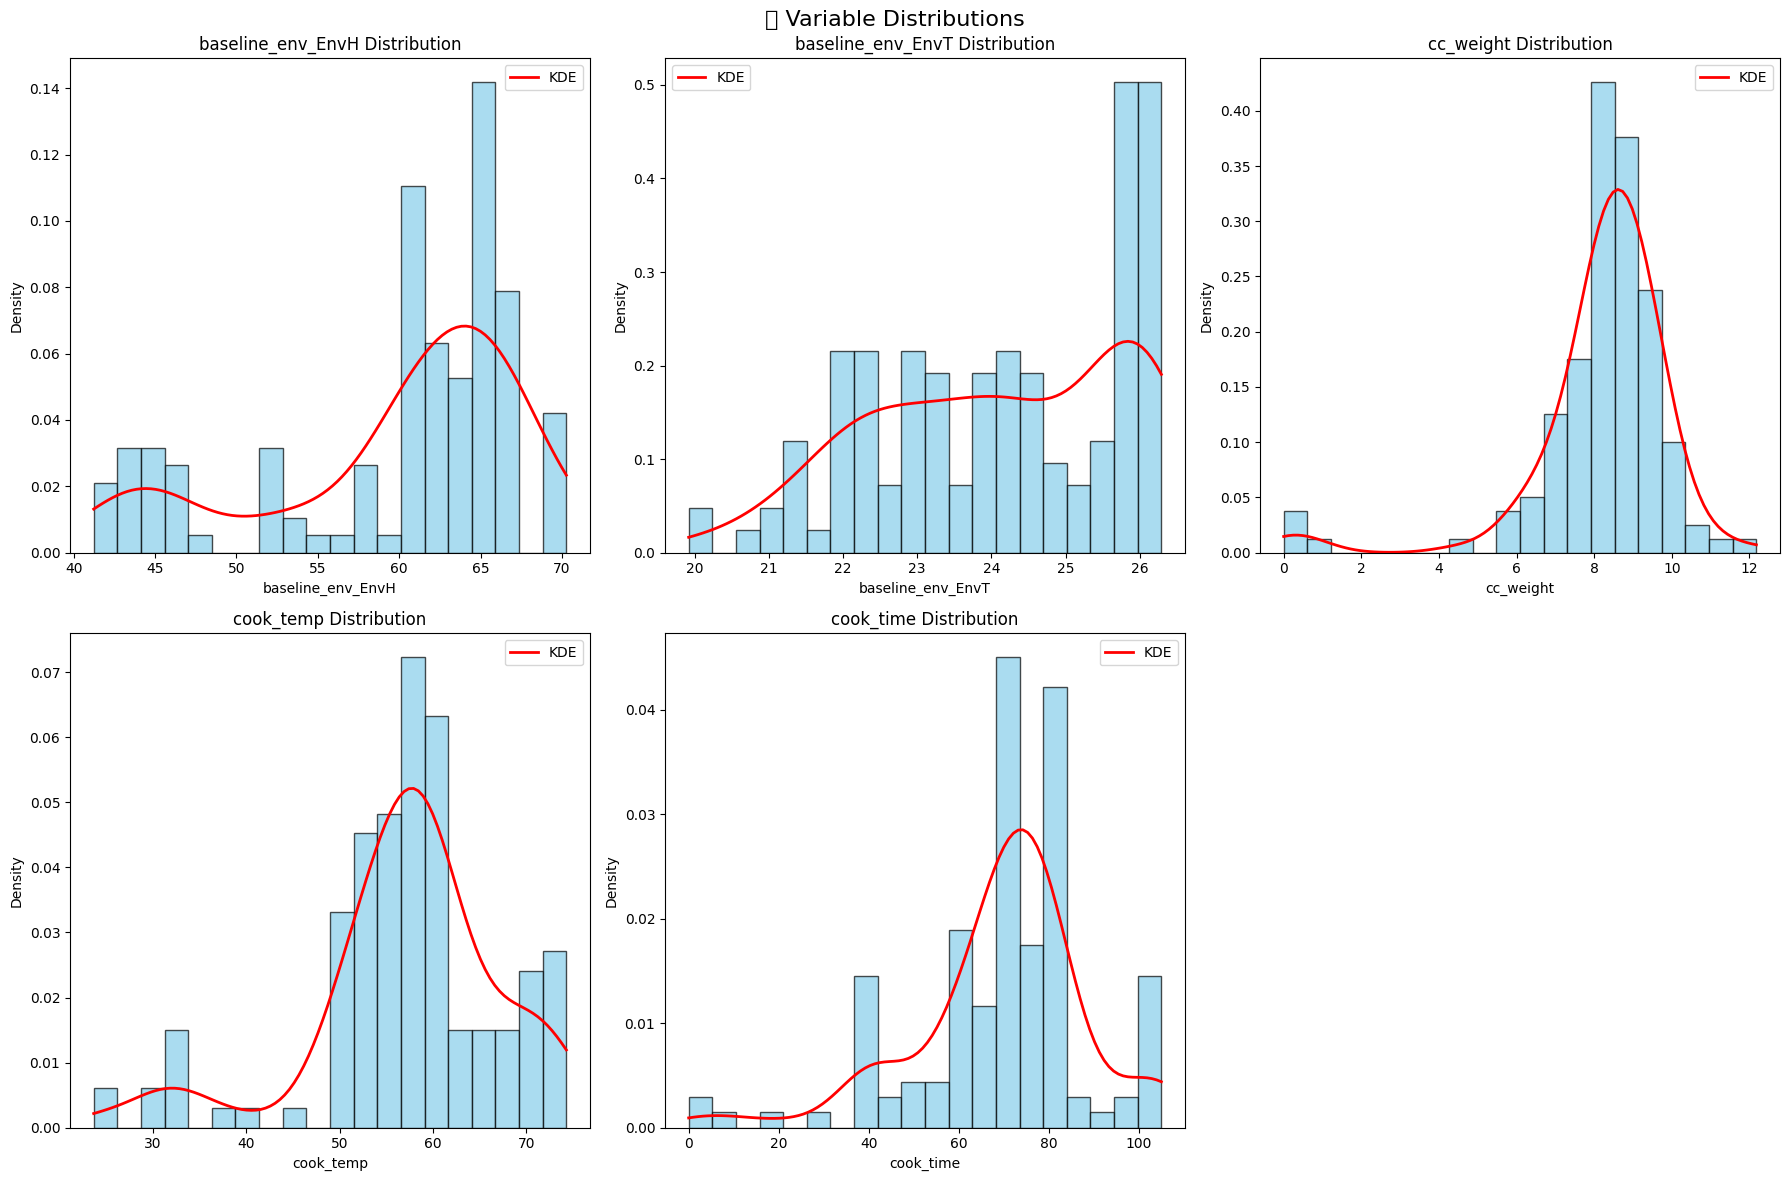


📈 DISTRIBUTION CHARACTERISTICS:
baseline_env_EnvH: Skew=-1.031 (Left-skewed), Kurtosis=-0.152, Shapiro p=0.000 (❌ Not Normal)
baseline_env_EnvT: Skew=-0.375 (Symmetric), Kurtosis=-0.968, Shapiro p=0.000 (❌ Not Normal)
cc_weight: Skew=-2.552 (Left-skewed), Kurtosis=9.320, Shapiro p=0.000 (❌ Not Normal)
cook_temp: Skew=-1.038 (Left-skewed), Kurtosis=1.742, Shapiro p=0.000 (❌ Not Normal)
cook_time: Skew=-0.929 (Left-skewed), Kurtosis=2.062, Shapiro p=0.000 (❌ Not Normal)


In [23]:
# 4. DISTRIBUTION ANALYSIS
print("=== 4. DISTRIBUTION ANALYSIS ===")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('📊 Variable Distributions', fontsize=16)

# Plot distributions
variables_to_plot = input_features + ['cc_weight', 'cook_temp', 'cook_time']
for i, var in enumerate(variables_to_plot):
    row = i // 3
    col = i % 3
    
    # Histogram with KDE
    axes[row, col].hist(clean_df[var], bins=20, alpha=0.7, density=True, color='skyblue', edgecolor='black')
    
    # Add KDE line
    from scipy import stats
    x_range = np.linspace(clean_df[var].min(), clean_df[var].max(), 100)
    kde = stats.gaussian_kde(clean_df[var])
    axes[row, col].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    
    axes[row, col].set_title(f'{var} Distribution')
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Density')
    axes[row, col].legend()

# Hide the last subplot if not needed
if len(variables_to_plot) < 6:
    axes[1, 2].set_visible(False)

plt.tight_layout()
plt.savefig(output_dir / 'variable_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Check for normality and skewness
print("\n📈 DISTRIBUTION CHARACTERISTICS:")
for var in variables_to_plot:
    skewness = stats.skew(clean_df[var])
    kurtosis = stats.kurtosis(clean_df[var])
    shapiro_stat, shapiro_p = stats.shapiro(clean_df[var])
    
    normal = "✅ Normal" if shapiro_p > 0.05 else "❌ Not Normal"
    skew_desc = "Right-skewed" if skewness > 0.5 else "Left-skewed" if skewness < -0.5 else "Symmetric"
    
    print(f"{var}: Skew={skewness:.3f} ({skew_desc}), Kurtosis={kurtosis:.3f}, Shapiro p={shapiro_p:.3f} ({normal})")

=== 5. ENVIRONMENTAL CONDITIONS ANALYSIS ===
🌡️ ENVIRONMENTAL CONDITIONS vs OUTCOMES:
                                cc_weight             cook_temp cook_time
                                    count  mean   std      mean      mean
humidity_category temp_category                                          
Low               Low                   3  7.82  1.37     52.00     67.67
                  Medium               19  8.44  0.96     53.00     71.58
                  High                  0   NaN   NaN       NaN       NaN
Medium            Low                  10  8.10  2.94     55.26     66.40
                  Medium               10  8.75  0.90     53.15     56.50
                  High                  9  7.36  2.12     52.24     79.44
High              Low                   2  8.40  1.08     39.56     75.00
                  Medium               22  8.05  2.67     54.99     66.36
                  High                 56  8.31  1.44     62.28     70.95


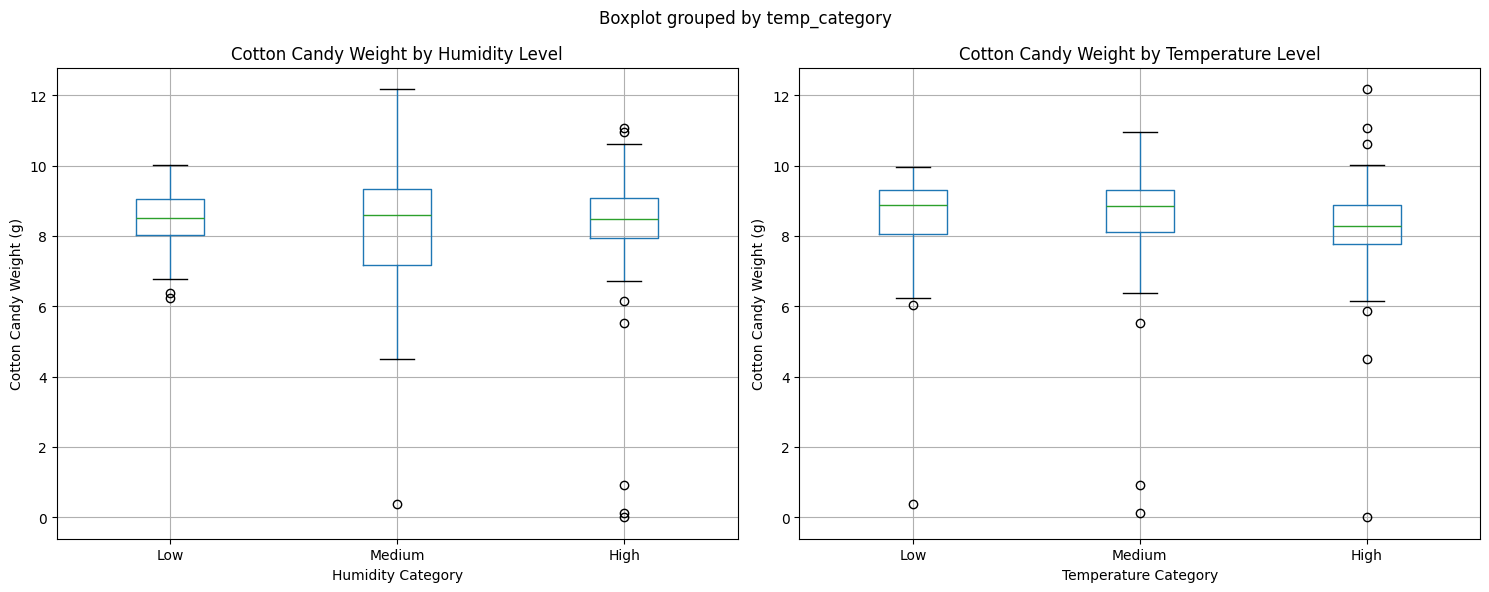


📊 STATISTICAL SIGNIFICANCE (ANOVA):
Humidity effect on weight: F=0.138, p=0.871 ❌ Not significant
Temperature effect on weight: F=0.161, p=0.852 ❌ Not significant


In [24]:
# 5. ENVIRONMENTAL CONDITIONS GROUPING
print("=== 5. ENVIRONMENTAL CONDITIONS ANALYSIS ===")

# Create humidity and temperature categories
clean_df['humidity_category'] = pd.cut(clean_df['baseline_env_EnvH'], 
                                     bins=3, labels=['Low', 'Medium', 'High'])
clean_df['temp_category'] = pd.cut(clean_df['baseline_env_EnvT'], 
                                 bins=3, labels=['Low', 'Medium', 'High'])

# Environmental conditions combinations
env_combinations = clean_df.groupby(['humidity_category', 'temp_category']).agg({
    'cc_weight': ['count', 'mean', 'std'],
    'cook_temp': 'mean',
    'cook_time': 'mean'
}).round(2)

print("🌡️ ENVIRONMENTAL CONDITIONS vs OUTCOMES:")
print(env_combinations)

# Box plots: Environmental categories vs cotton candy weight
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Humidity categories vs weight
clean_df.boxplot(column='cc_weight', by='humidity_category', ax=axes[0])
axes[0].set_title('Cotton Candy Weight by Humidity Level')
axes[0].set_xlabel('Humidity Category')
axes[0].set_ylabel('Cotton Candy Weight (g)')

# Temperature categories vs weight  
clean_df.boxplot(column='cc_weight', by='temp_category', ax=axes[1])
axes[1].set_title('Cotton Candy Weight by Temperature Level')
axes[1].set_xlabel('Temperature Category')
axes[1].set_ylabel('Cotton Candy Weight (g)')

plt.tight_layout()
plt.savefig(output_dir / 'environmental_categories_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical significance tests
from scipy.stats import f_oneway

humidity_groups = [clean_df[clean_df['humidity_category'] == cat]['cc_weight'] for cat in ['Low', 'Medium', 'High']]
temp_groups = [clean_df[clean_df['temp_category'] == cat]['cc_weight'] for cat in ['Low', 'Medium', 'High']]

f_stat_hum, p_val_hum = f_oneway(*humidity_groups)
f_stat_temp, p_val_temp = f_oneway(*temp_groups)

print(f"\n📊 STATISTICAL SIGNIFICANCE (ANOVA):")
print(f"Humidity effect on weight: F={f_stat_hum:.3f}, p={p_val_hum:.3f} {'✅ Significant' if p_val_hum < 0.05 else '❌ Not significant'}")
print(f"Temperature effect on weight: F={f_stat_temp:.3f}, p={p_val_temp:.3f} {'✅ Significant' if p_val_temp < 0.05 else '❌ Not significant'}")

In [25]:
# 6. KEY INSIGHTS AND NEXT STEPS
print("=== 6. KEY INSIGHTS & MODELING RECOMMENDATIONS ===")

# Calculate some key statistics for insights
env_range_humidity = clean_df['baseline_env_EnvH'].max() - clean_df['baseline_env_EnvH'].min()
env_range_temp = clean_df['baseline_env_EnvT'].max() - clean_df['baseline_env_EnvT'].min()
weight_range = clean_df['cc_weight'].max() - clean_df['cc_weight'].min()

print("🎯 KEY FINDINGS:")
print(f"1. Environmental Ranges:")
print(f"   - Humidity: {clean_df['baseline_env_EnvH'].min():.1f}% to {clean_df['baseline_env_EnvH'].max():.1f}% (range: {env_range_humidity:.1f}%)")
print(f"   - Temperature: {clean_df['baseline_env_EnvT'].min():.1f}°C to {clean_df['baseline_env_EnvT'].max():.1f}°C (range: {env_range_temp:.1f}°C)")

print(f"\n2. Cotton Candy Weight Variation:")
print(f"   - Range: {clean_df['cc_weight'].min():.2f}g to {clean_df['cc_weight'].max():.2f}g ({weight_range:.2f}g variation)")
print(f"   - Mean: {clean_df['cc_weight'].mean():.2f}g (±{clean_df['cc_weight'].std():.2f}g)")

# Top correlations with weight
weight_correlations = correlation_matrix['cc_weight'].abs().sort_values(ascending=False)
strongest_predictors = weight_correlations[weight_correlations.index != 'cc_weight'].head(3)

print(f"\n3. Strongest Predictors of Cotton Candy Weight:")
for var, corr in strongest_predictors.items():
    print(f"   - {var}: |r| = {corr:.3f}")

print(f"\n🚀 NEXT STEPS FOR MODELING:")
print("1. ✅ Data is clean and ready (131 samples, 75.3% retention)")
print("2. 🎯 Clear input-output structure: Environment → Process Parameters + Weight")
print("3. 🔍 Try these modeling approaches:")
print("   - Linear Regression (baseline model)")
print("   - Random Forest (capture non-linear relationships)")  
print("   - Neural Network (if complex interactions exist)")
print("4. 📊 Evaluation strategies:")
print("   - Cross-validation for robust performance estimates")
print("   - Feature importance analysis")
print("   - Prediction intervals for uncertainty quantification")

print(f"\n📁 Files saved in {output_dir.absolute()}:")
saved_files = [
    'cleaned_cotton_candy_data.csv',
    'correlation_matrix.png',
    'environment_vs_targets.png', 
    'variable_distributions.png',
    'environmental_categories_analysis.png'
]
for file in saved_files:
    print(f"   - {file}")

print("\n🎭 READY TO BUILD YOUR COTTON CANDY DIGITAL TWIN! 🍭")

=== 6. KEY INSIGHTS & MODELING RECOMMENDATIONS ===
🎯 KEY FINDINGS:
1. Environmental Ranges:
   - Humidity: 41.2% to 70.3% (range: 29.0%)
   - Temperature: 19.9°C to 26.3°C (range: 6.4°C)

2. Cotton Candy Weight Variation:
   - Range: 0.00g to 12.18g (12.18g variation)
   - Mean: 8.23g (±1.79g)

3. Strongest Predictors of Cotton Candy Weight:
   - cook_time: |r| = 0.364
   - cooled_temp: |r| = 0.105
   - cook_temp: |r| = 0.102

🚀 NEXT STEPS FOR MODELING:
1. ✅ Data is clean and ready (131 samples, 75.3% retention)
2. 🎯 Clear input-output structure: Environment → Process Parameters + Weight
3. 🔍 Try these modeling approaches:
   - Linear Regression (baseline model)
   - Random Forest (capture non-linear relationships)
   - Neural Network (if complex interactions exist)
4. 📊 Evaluation strategies:
   - Cross-validation for robust performance estimates
   - Feature importance analysis
   - Prediction intervals for uncertainty quantification

📁 Files saved in /Users/nicolas/Desktop/Cotton-Ca

In [29]:
# ===== DATA QUALITY COMPARISON: RECENT vs RANDOM ITERATIONS =====
print("=== DATA QUALITY ANALYSIS: RECENT vs RANDOM SUBSETS ===")
print("🔍 Hypothesis: Recent iterations might have better data quality and stronger correlations")

# Use df_clean which still has iteration numbers (before we removed them for the final dataset)
clean_df_with_iterations = df_clean.copy()  # This still has iteration column
print(f"Dataset with iterations shape: {clean_df_with_iterations.shape}")
print(f"Columns available: {list(clean_df_with_iterations.columns)}")

# Sort by iteration number and get subsets
clean_df_sorted = clean_df_with_iterations.sort_values('iteration')
print(f"Total iterations: {clean_df_sorted['iteration'].min():.0f} to {clean_df_sorted['iteration'].max():.0f}")

# Get last 30 iterations
last_30 = clean_df_sorted.tail(30).copy()
print(f"Last 30 iterations: {len(last_30)} samples (iterations {last_30['iteration'].min():.0f}-{last_30['iteration'].max():.0f})")

# Get random 30 iterations (for comparison)
np.random.seed(42)  # For reproducibility
random_30 = clean_df_sorted.sample(n=30, random_state=42).copy()
print(f"Random 30 iterations: {len(random_30)} samples")

# Get first 30 iterations (oldest data)
first_30 = clean_df_sorted.head(30).copy()
print(f"First 30 iterations: {len(first_30)} samples (iterations {first_30['iteration'].min():.0f}-{first_30['iteration'].max():.0f})")

=== DATA QUALITY ANALYSIS: RECENT vs RANDOM SUBSETS ===
🔍 Hypothesis: Recent iterations might have better data quality and stronger correlations
Dataset with iterations shape: (131, 52)
Columns available: ['iteration', 'batch_number', 'stick_number', 'index_log', 'stick_weight', 'sugar_amount', 'iteration_since_maintenance', 'wait_time', 'cook_time', 'cooldown_time', 'start_temp', 'cook_temp', 'cooled_temp', 'duration_till_handover', 'duration_total', 'show_start_time', 'show_end_time', 'duration_cc_flow', 'diff_flow', 'diff_flow_stop', 'baseline_env_EnvH', 'baseline_env_EnvT', 'before_turn_on_env_InH', 'before_turn_on_env_InT', 'before_turn_on_env_IrO', 'before_turn_on_env_IrA', 'after_flow_start_env_InH', 'after_flow_start_env_InT', 'after_flow_start_env_IrO', 'after_flow_start_env_IrA', 'after_flow_end_env_InH', 'after_flow_end_env_InT', 'after_flow_end_env_IrO', 'after_flow_end_env_IrA', 'before_cooldown_env_InH', 'before_cooldown_env_InT', 'before_cooldown_env_IrO', 'before_cooldo


=== CORRELATION COMPARISON ===

📊 All Data (131 samples):
   Environmental Correlations with Weight:
     - baseline_env_EnvH: |r| = 0.024 (⚪ Weak)
     - baseline_env_EnvT: |r| = 0.010 (⚪ Weak)
   Top 3 Predictors:
     - quality_score: |r| = 0.802 (🔴 Strong)
     - diff_flow_stop: |r| = 0.516 (🟡 Moderate)
     - max_pos1: |r| = 0.460 (🟡 Moderate)

📊 Last 30 Iterations:
   Environmental Correlations with Weight:
     - baseline_env_EnvH: |r| = 0.166 (⚪ Weak)
     - baseline_env_EnvT: |r| = 0.095 (⚪ Weak)
   Top 3 Predictors:
     - quality_score: |r| = 0.881 (🔴 Strong)
     - max_pos1: |r| = 0.682 (🟡 Moderate)
     - diff_flow_stop: |r| = 0.520 (🟡 Moderate)

📊 Random 30 Iterations:
   Environmental Correlations with Weight:
     - baseline_env_EnvH: |r| = 0.017 (⚪ Weak)
     - baseline_env_EnvT: |r| = 0.001 (⚪ Weak)
   Top 3 Predictors:
     - diff_flow: |r| = 0.890 (🔴 Strong)
     - quality_score: |r| = 0.871 (🔴 Strong)
     - diff_flow_stop: |r| = 0.722 (🔴 Strong)

📊 First 30 Itera

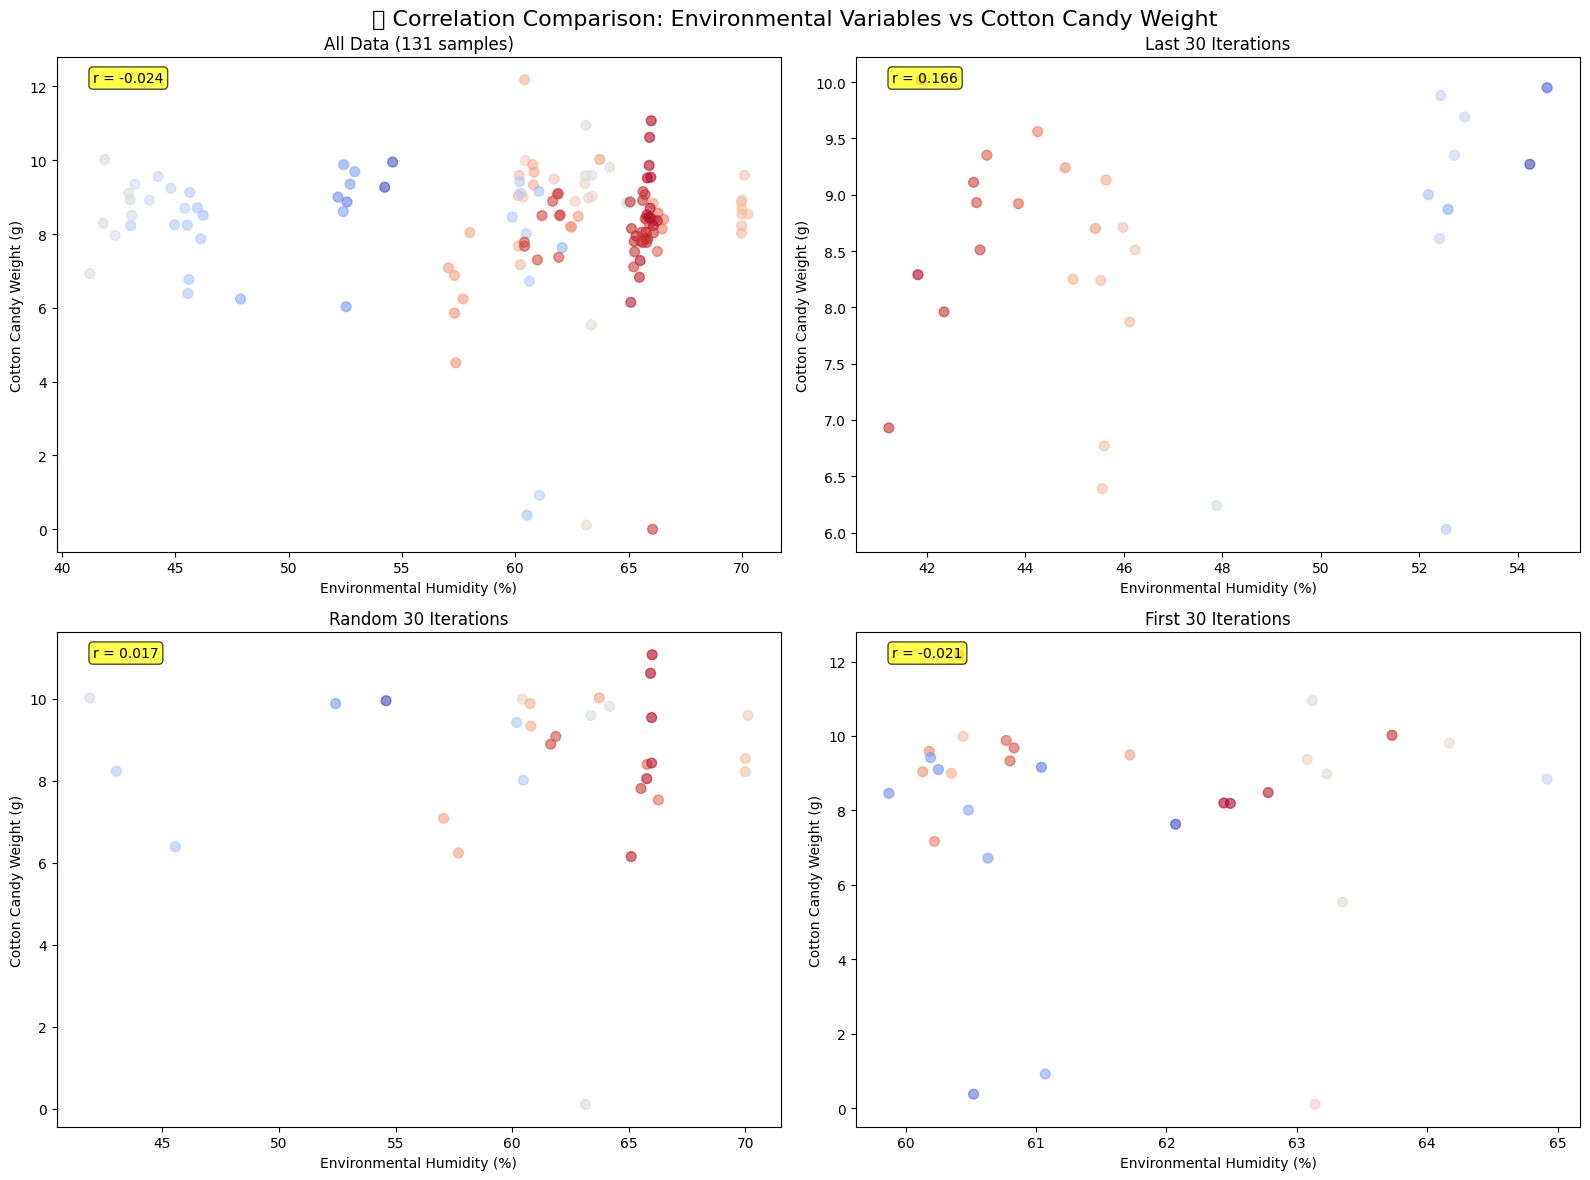

In [30]:
# CORRELATION COMPARISON ACROSS SUBSETS
print("\n=== CORRELATION COMPARISON ===")

subsets = {
    'All Data (131 samples)': clean_df_sorted,
    'Last 30 Iterations': last_30,
    'Random 30 Iterations': random_30,
    'First 30 Iterations': first_30
}

# Analyze correlations for each subset
correlation_results = {}
for subset_name, subset_df in subsets.items():
    # Calculate correlations with cc_weight
    numeric_cols = [col for col in subset_df.select_dtypes(include=[np.number]).columns if col not in ['iteration']]
    
    if len(subset_df) > 10:  # Only analyze if we have enough samples
        corr_with_weight = subset_df[numeric_cols].corr()['cc_weight'].abs().sort_values(ascending=False)
        
        # Store results
        correlation_results[subset_name] = corr_with_weight
        
        print(f"\n📊 {subset_name}:")
        print(f"   Environmental Correlations with Weight:")
        for env_var in ['baseline_env_EnvH', 'baseline_env_EnvT']:
            if env_var in corr_with_weight.index:
                corr_val = corr_with_weight[env_var]
                strength = "🔴 Strong" if corr_val > 0.7 else "🟡 Moderate" if corr_val > 0.3 else "⚪ Weak"
                print(f"     - {env_var}: |r| = {corr_val:.3f} ({strength})")
        
        print(f"   Top 3 Predictors:")
        top_predictors = corr_with_weight[corr_with_weight.index != 'cc_weight'].head(3)
        for var, corr in top_predictors.items():
            strength = "🔴 Strong" if corr > 0.7 else "🟡 Moderate" if corr > 0.3 else "⚪ Weak"
            print(f"     - {var}: |r| = {corr:.3f} ({strength})")

# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🔍 Correlation Comparison: Environmental Variables vs Cotton Candy Weight', fontsize=16)

plot_configs = [
    ('All Data (131 samples)', (0, 0)),
    ('Last 30 Iterations', (0, 1)),
    ('Random 30 Iterations', (1, 0)),
    ('First 30 Iterations', (1, 1))
]

for subset_name, (row, col) in plot_configs:
    subset_df = subsets[subset_name]
    if len(subset_df) > 10:
        # Scatter plot: Environment vs Weight
        scatter = axes[row, col].scatter(subset_df['baseline_env_EnvH'], subset_df['cc_weight'], 
                                       alpha=0.6, c=subset_df['baseline_env_EnvT'], cmap='coolwarm', s=50)
        axes[row, col].set_xlabel('Environmental Humidity (%)')
        axes[row, col].set_ylabel('Cotton Candy Weight (g)')
        axes[row, col].set_title(f'{subset_name}')
        
        # Add correlation coefficient to plot
        corr_hum = subset_df['baseline_env_EnvH'].corr(subset_df['cc_weight'])
        axes[row, col].text(0.05, 0.95, f'r = {corr_hum:.3f}', transform=axes[row, col].transAxes, 
                          bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.savefig(output_dir / 'iteration_subset_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# DATA QUALITY METRICS COMPARISON
print("\n=== DATA QUALITY METRICS ===")

quality_metrics = {}
for subset_name, subset_df in subsets.items():
    if len(subset_df) > 10:
        metrics = {}
        
        # Environmental variability (good experiments should have varied conditions)
        metrics['env_humidity_range'] = subset_df['baseline_env_EnvH'].max() - subset_df['baseline_env_EnvH'].min()
        metrics['env_temp_range'] = subset_df['baseline_env_EnvT'].max() - subset_df['baseline_env_EnvT'].min()
        
        # Weight outcome consistency (lower CV = more consistent)
        metrics['weight_mean'] = subset_df['cc_weight'].mean()
        metrics['weight_cv'] = (subset_df['cc_weight'].std() / subset_df['cc_weight'].mean()) * 100  # Coefficient of variation
        
        # Process parameter consistency
        metrics['cook_temp_cv'] = (subset_df['cook_temp'].std() / subset_df['cook_temp'].mean()) * 100
        metrics['cook_time_cv'] = (subset_df['cook_time'].std() / subset_df['cook_time'].mean()) * 100
        
        # Data completeness (should be 100% since we cleaned)
        metrics['completeness'] = (1 - subset_df.isnull().sum().sum() / (len(subset_df) * len(subset_df.columns))) * 100
        
        quality_metrics[subset_name] = metrics
        
        print(f"\n📊 {subset_name} Quality Metrics:")
        print(f"   Environmental Ranges: Humidity={metrics['env_humidity_range']:.1f}%, Temp={metrics['env_temp_range']:.1f}°C")
        print(f"   Weight: Mean={metrics['weight_mean']:.2f}g, CV={metrics['weight_cv']:.1f}%")
        print(f"   Process Consistency: CookTemp CV={metrics['cook_temp_cv']:.1f}%, CookTime CV={metrics['cook_time_cv']:.1f}%")

# Create quality comparison table
print("\n=== QUALITY COMPARISON TABLE ===")
quality_df = pd.DataFrame(quality_metrics).T
quality_df = quality_df.round(2)
print(quality_df)

# Identify experimental issues
print("\n🚨 EXPERIMENTAL QUALITY ASSESSMENT:")
print("\n1. Environmental Range Coverage:")
for subset_name in subsets.keys():
    if subset_name in quality_metrics:
        hum_range = quality_metrics[subset_name]['env_humidity_range']
        temp_range = quality_metrics[subset_name]['env_temp_range']
        coverage = "✅ Good" if hum_range > 15 and temp_range > 3 else "⚠️ Limited" if hum_range > 5 or temp_range > 1 else "❌ Poor"
        print(f"   {subset_name}: {coverage} (H:{hum_range:.1f}%, T:{temp_range:.1f}°C)")

print("\n2. Weight Measurement Consistency (lower CV = better):")
for subset_name in subsets.keys():
    if subset_name in quality_metrics:
        cv = quality_metrics[subset_name]['weight_cv']
        consistency = "✅ Good" if cv < 20 else "⚠️ Moderate" if cv < 30 else "❌ Poor"
        print(f"   {subset_name}: {consistency} (CV: {cv:.1f}%)")

print("\n3. Process Control Consistency:")
for subset_name in subsets.keys():
    if subset_name in quality_metrics:
        cook_temp_cv = quality_metrics[subset_name]['cook_temp_cv']
        cook_time_cv = quality_metrics[subset_name]['cook_time_cv']
        control = "✅ Good" if cook_temp_cv < 10 and cook_time_cv < 5 else "⚠️ Moderate" if cook_temp_cv < 20 or cook_time_cv < 10 else "❌ Poor"
        print(f"   {subset_name}: {control} (TempCV:{cook_temp_cv:.1f}%, TimeCV:{cook_time_cv:.1f}%)")


=== DATA QUALITY METRICS ===

📊 All Data (131 samples) Quality Metrics:
   Environmental Ranges: Humidity=29.0%, Temp=6.4°C
   Weight: Mean=8.23g, CV=21.8%
   Process Consistency: CookTemp CV=17.7%, CookTime CV=27.4%

📊 Last 30 Iterations Quality Metrics:
   Environmental Ranges: Humidity=13.4%, Temp=3.3°C
   Weight: Mean=8.54g, CV=12.9%
   Process Consistency: CookTemp CV=4.3%, CookTime CV=10.7%

📊 Random 30 Iterations Quality Metrics:
   Environmental Ranges: Humidity=28.2%, Temp=6.2°C
   Weight: Mean=8.53g, CV=23.9%
   Process Consistency: CookTemp CV=17.8%, CookTime CV=28.7%

📊 First 30 Iterations Quality Metrics:
   Environmental Ranges: Humidity=5.1%, Temp=3.1°C
   Weight: Mean=8.12g, CV=35.4%
   Process Consistency: CookTemp CV=21.8%, CookTime CV=47.4%

=== QUALITY COMPARISON TABLE ===
                        env_humidity_range  env_temp_range  weight_mean  \
All Data (131 samples)               29.04            6.37         8.23   
Last 30 Iterations                   13.36   

In [32]:
# RECOMMENDATIONS FOR BETTER DATA COLLECTION
print("\n=== RECOMMENDATIONS FOR IMPROVING DATA QUALITY ===")

# Find the best performing subset based on environmental correlations
best_subset = None
best_env_corr = 0
for subset_name in subsets.keys():
    if subset_name in correlation_results:
        env_corr = 0
        for env_var in ['baseline_env_EnvH', 'baseline_env_EnvT']:
            if env_var in correlation_results[subset_name].index:
                env_corr += correlation_results[subset_name][env_var]
        if env_corr > best_env_corr:
            best_env_corr = env_corr
            best_subset = subset_name

print(f"🏆 BEST PERFORMING SUBSET: {best_subset}")
print(f"   Combined environmental correlation: {best_env_corr:.3f}")

print("\n📋 RECOMMENDATIONS:")
print("1. 🔬 EXPERIMENTAL DESIGN:")
print("   - Plan humidity levels: Cover 40-70% in systematic steps (e.g., 40%, 50%, 60%, 70%)")
print("   - Plan temperature levels: Cover 20-26°C in systematic steps (e.g., 20°C, 22°C, 24°C, 26°C)")
print("   - Repeat each env. condition 3-5 times for statistical power")
print("   - Use factorial design: 4×4×3 = 48 planned experiments")

print("\n2. 🎛️ PROCESS CONTROL:")
print("   - Standardize cotton candy machine setup before each experiment")
print("   - Use consistent sugar amount and type")
print("   - Control room conditions beyond just humidity/temperature")
print("   - Document machine maintenance/calibration dates")

print("\n3. 📊 DATA COLLECTION:")
print("   - Measure weight immediately after production (minimize moisture loss)")
print("   - Use precision scale (±0.01g accuracy)")
print("   - Record exact timestamps for all measurements")
print("   - Document any anomalies or equipment issues")

print("\n4. 🤖 MODELING APPROACH (given current data limitations):")
if best_env_corr < 0.5:
    print("   - Current correlations are too weak for reliable environmental prediction")
    print("   - Focus on process parameter relationships (cook_time shows |r|=0.364)")
    print("   - Consider non-linear models (Random Forest, XGBoost)")
    print("   - Use ensemble methods to capture weak signals")
    print("   - Consider clustering similar experiments")
else:
    print("   - Environmental correlations are promising for modeling")
    print("   - Start with linear regression as baseline")
    print("   - Try polynomial features for non-linear relationships")

print(f"\n💾 BEST SUBSET FOR CURRENT MODELING:")
if best_subset:
    best_df = subsets[best_subset]
    output_file_best = output_dir / f'best_subset_{best_subset.lower().replace(" ", "_").replace("(", "").replace(")", "")}.csv'
    best_df.to_csv(output_file_best, index=False)
    print(f"   - Saved: {output_file_best}")
    print(f"   - Size: {len(best_df)} samples")
    print(f"   - Use this subset for initial model development")

print("\n🎯 NEXT EXPERIMENT PRIORITIES:")
print("1. Collect 20-30 samples with HIGH humidity (65-70%) at different temperatures")
print("2. Collect 20-30 samples with LOW humidity (40-45%) at different temperatures") 
print("3. Focus on systematic environmental variation rather than random conditions")
print("4. Validate that environmental sensors are properly calibrated")

print(f"\n📁 New files saved:")
print("   - iteration_subset_comparison.png")
if best_subset:
    print(f"   - best_subset_{best_subset.lower().replace(' ', '_').replace('(', '').replace(')', '')}.csv")


=== RECOMMENDATIONS FOR IMPROVING DATA QUALITY ===
🏆 BEST PERFORMING SUBSET: First 30 Iterations
   Combined environmental correlation: 0.380

📋 RECOMMENDATIONS:
1. 🔬 EXPERIMENTAL DESIGN:
   - Plan humidity levels: Cover 40-70% in systematic steps (e.g., 40%, 50%, 60%, 70%)
   - Plan temperature levels: Cover 20-26°C in systematic steps (e.g., 20°C, 22°C, 24°C, 26°C)
   - Repeat each env. condition 3-5 times for statistical power
   - Use factorial design: 4×4×3 = 48 planned experiments

2. 🎛️ PROCESS CONTROL:
   - Standardize cotton candy machine setup before each experiment
   - Use consistent sugar amount and type
   - Control room conditions beyond just humidity/temperature
   - Document machine maintenance/calibration dates

3. 📊 DATA COLLECTION:
   - Measure weight immediately after production (minimize moisture loss)
   - Use precision scale (±0.01g accuracy)
   - Record exact timestamps for all measurements
   - Document any anomalies or equipment issues

4. 🤖 MODELING APPROAC

In [33]:
# ===== REAL-WORLD CONTROL SCENARIO ANALYSIS =====
print("=== REAL-WORLD COTTON CANDY CONTROL SCENARIO ===")
print("🎯 ACTUAL PROBLEM: Given environmental conditions → Optimize process parameters → Achieve target weight/quality")
print("\n📊 CONTROL HIERARCHY:")
print("   UNCONTROLLABLE INPUTS: Environmental Humidity & Temperature")
print("   CONTROLLABLE OUTPUTS: Process Parameters (cook_temp, start_temp, cooled_temp, cook_time)")
print("   TARGET OUTCOMES: Cotton Candy Weight & Quality")

# Use the dataset with iterations for this analysis
control_df = clean_df_with_iterations.copy()

print(f"\n📈 ANALYSIS FOCUS:")
print("1. How do environmental conditions affect optimal process parameters?")
print("2. What process adjustments compensate for different environments?")
print("3. Can we predict optimal settings for any given environment?")

# Create environmental condition categories for clearer analysis
control_df['env_category'] = 'Medium'  # Default
humidity_low_thresh = control_df['baseline_env_EnvH'].quantile(0.33)
humidity_high_thresh = control_df['baseline_env_EnvH'].quantile(0.67)
temp_low_thresh = control_df['baseline_env_EnvT'].quantile(0.33)
temp_high_thresh = control_df['baseline_env_EnvT'].quantile(0.67)

print(f"\n🌡️ ENVIRONMENTAL THRESHOLDS:")
print(f"   Humidity: Low<{humidity_low_thresh:.1f}%, Medium={humidity_low_thresh:.1f}-{humidity_high_thresh:.1f}%, High>{humidity_high_thresh:.1f}%")
print(f"   Temperature: Low<{temp_low_thresh:.1f}°C, Medium={temp_low_thresh:.1f}-{temp_high_thresh:.1f}°C, High>{temp_high_thresh:.1f}°C")

# Create combined environmental categories
conditions = []
for _, row in control_df.iterrows():
    humidity_level = 'Low' if row['baseline_env_EnvH'] < humidity_low_thresh else 'High' if row['baseline_env_EnvH'] > humidity_high_thresh else 'Med'
    temp_level = 'Low' if row['baseline_env_EnvT'] < temp_low_thresh else 'High' if row['baseline_env_EnvT'] > temp_high_thresh else 'Med'
    conditions.append(f"{humidity_level}H-{temp_level}T")

control_df['env_category'] = conditions
print(f"\n📊 ENVIRONMENTAL COMBINATIONS:")
print(control_df['env_category'].value_counts())

=== REAL-WORLD COTTON CANDY CONTROL SCENARIO ===
🎯 ACTUAL PROBLEM: Given environmental conditions → Optimize process parameters → Achieve target weight/quality

📊 CONTROL HIERARCHY:
   UNCONTROLLABLE INPUTS: Environmental Humidity & Temperature
   CONTROLLABLE OUTPUTS: Process Parameters (cook_temp, start_temp, cooled_temp, cook_time)
   TARGET OUTCOMES: Cotton Candy Weight & Quality

📈 ANALYSIS FOCUS:
1. How do environmental conditions affect optimal process parameters?
2. What process adjustments compensate for different environments?
3. Can we predict optimal settings for any given environment?

🌡️ ENVIRONMENTAL THRESHOLDS:
   Humidity: Low<60.2%, Medium=60.2-65.3%, High>65.3%
   Temperature: Low<23.2°C, Medium=23.2-25.6°C, High>25.6°C

📊 ENVIRONMENTAL COMBINATIONS:
env_category
LowH-LowT      32
HighH-HighT    27
MedH-MedT      19
MedH-HighT     16
HighH-MedT     16
LowH-MedT      11
MedH-LowT      10
Name: count, dtype: int64



=== OPTIMAL PROCESS PARAMETERS BY ENVIRONMENT ===

🎯 MedH-MedT CONDITIONS:
   Samples: 19, Avg Weight: 8.80g
   Top Performers (4 samples, weight ≥ 9.92g):
     cook_temp: 39.2 (↓ -18.0 vs overall avg)
     start_temp: 35.5 (↓ -19.5 vs overall avg)
     cooled_temp: 61.3 (↓ -0.1 vs overall avg)
     cook_time: 95.0 (↑ +25.6 vs overall avg)

🎯 LowH-MedT CONDITIONS:
   Samples: 11, Avg Weight: 7.31g
   Top Performers (3 samples, weight ≥ 8.29g):
     cook_temp: 58.2 (↑ +1.0 vs overall avg)
     start_temp: 56.7 (↑ +1.7 vs overall avg)
     cooled_temp: 60.6 (↓ -0.9 vs overall avg)
     cook_time: 63.3 (↓ -6.1 vs overall avg)

🎯 MedH-LowT CONDITIONS:
   Samples: 10, Avg Weight: 6.99g
   Top Performers (2 samples, weight ≥ 9.24g):
     cook_temp: 54.5 (↓ -2.7 vs overall avg)
     start_temp: 54.2 (↓ -0.8 vs overall avg)
     cooled_temp: 59.2 (↓ -2.3 vs overall avg)
     cook_time: 87.5 (↑ +18.1 vs overall avg)

🎯 LowH-LowT CONDITIONS:
   Samples: 32, Avg Weight: 8.57g
   Top Performers (

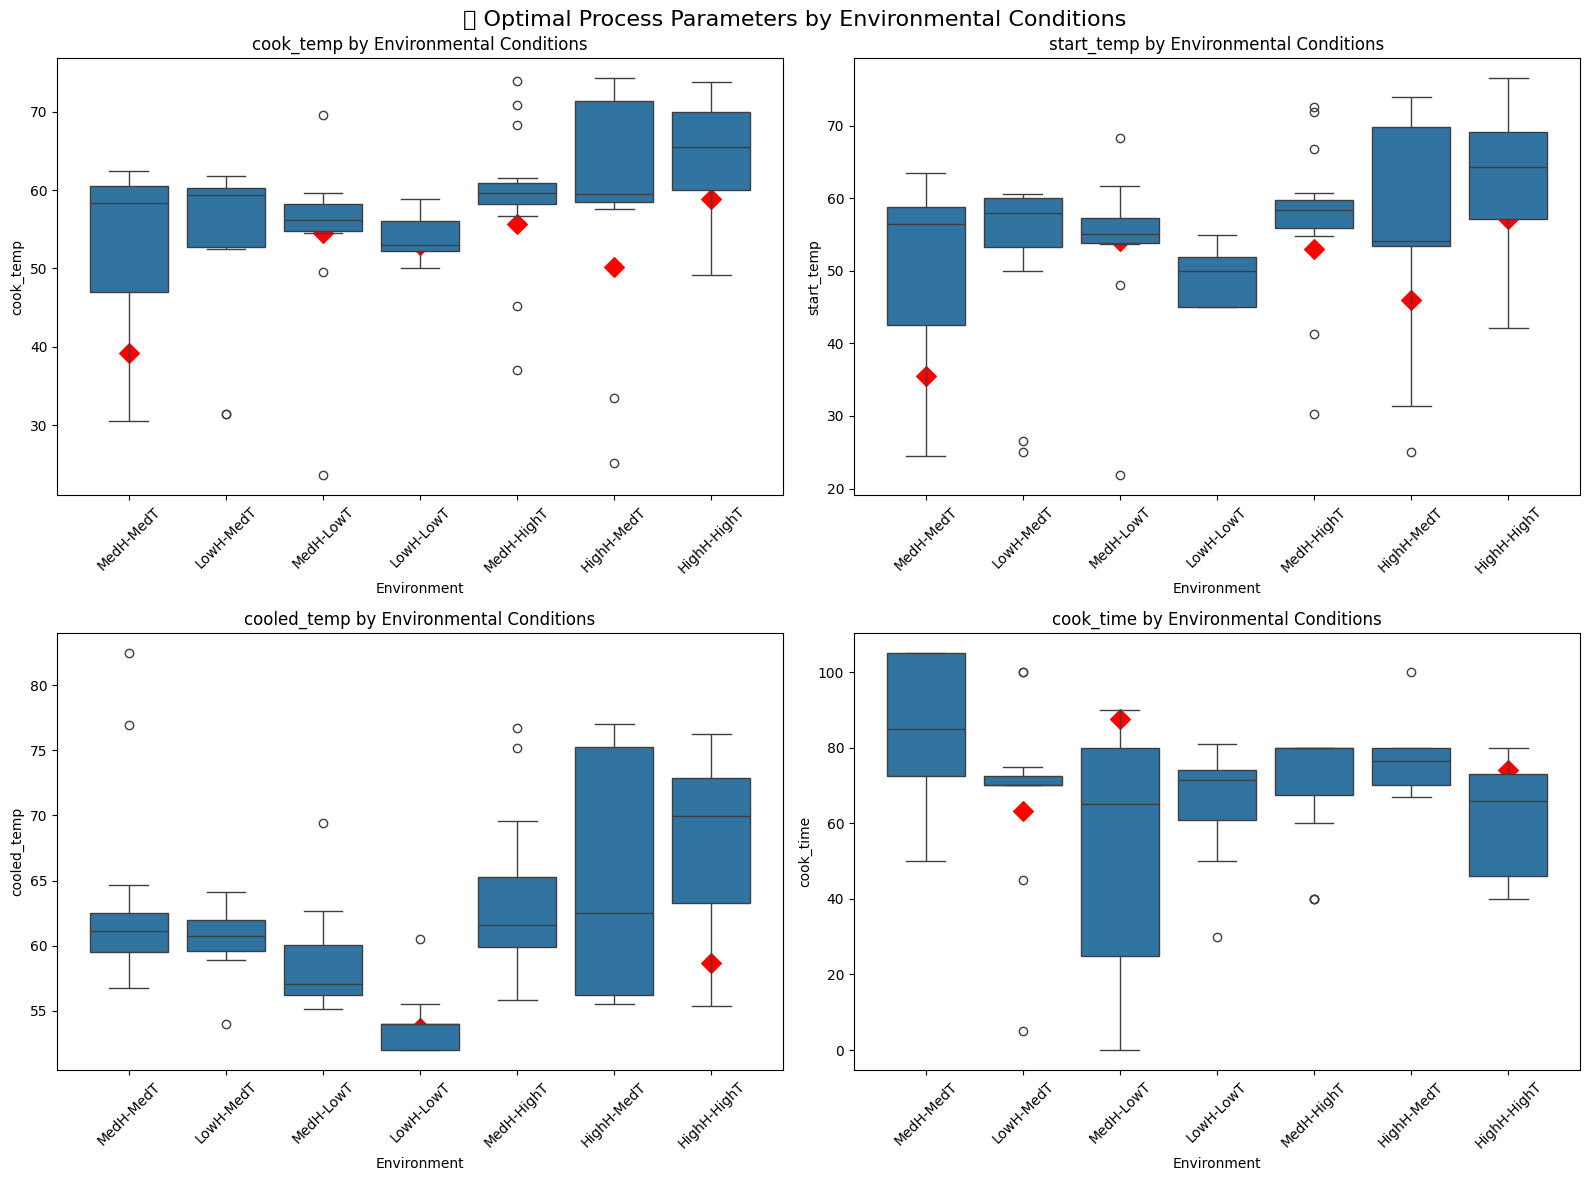

In [34]:
# OPTIMAL PROCESS PARAMETERS BY ENVIRONMENTAL CONDITIONS
print("\n=== OPTIMAL PROCESS PARAMETERS BY ENVIRONMENT ===")

# Find best performing samples (highest weight) in each environmental category
process_params = ['cook_temp', 'start_temp', 'cooled_temp', 'cook_time']

optimal_settings = {}
for env_cat in control_df['env_category'].unique():
    env_subset = control_df[control_df['env_category'] == env_cat]
    if len(env_subset) >= 3:  # Need at least 3 samples for meaningful analysis
        
        # Find top 20% performers in this environment
        weight_threshold = env_subset['cc_weight'].quantile(0.8)
        top_performers = env_subset[env_subset['cc_weight'] >= weight_threshold]
        
        optimal_settings[env_cat] = {
            'count': len(env_subset),
            'avg_weight': env_subset['cc_weight'].mean(),
            'best_weight': env_subset['cc_weight'].max(),
            'top_performers': len(top_performers)
        }
        
        # Calculate optimal process parameters (mean of top performers)
        for param in process_params:
            optimal_settings[env_cat][f'optimal_{param}'] = top_performers[param].mean()
        
        print(f"\n🎯 {env_cat} CONDITIONS:")
        print(f"   Samples: {len(env_subset)}, Avg Weight: {env_subset['cc_weight'].mean():.2f}g")
        print(f"   Top Performers ({len(top_performers)} samples, weight ≥ {weight_threshold:.2f}g):")
        for param in process_params:
            optimal_val = top_performers[param].mean()
            overall_avg = control_df[param].mean()
            diff = optimal_val - overall_avg
            arrow = "↑" if diff > 0 else "↓" if diff < 0 else "→"
            print(f"     {param}: {optimal_val:.1f} ({arrow} {diff:+.1f} vs overall avg)")

# Create visualization of optimal settings
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🎛️ Optimal Process Parameters by Environmental Conditions', fontsize=16)

for i, param in enumerate(process_params):
    row, col = i // 2, i % 2
    
    # Box plot of parameter values by environmental category
    env_categories = []
    param_values = []
    
    for env_cat in control_df['env_category'].unique():
        env_subset = control_df[control_df['env_category'] == env_cat]
        if len(env_subset) >= 3:
            env_categories.extend([env_cat] * len(env_subset))
            param_values.extend(env_subset[param].values)
    
    # Create DataFrame for seaborn
    plot_df = pd.DataFrame({'Environment': env_categories, param: param_values})
    
    # Box plot
    sns.boxplot(data=plot_df, x='Environment', y=param, ax=axes[row, col])
    axes[row, col].set_title(f'{param} by Environmental Conditions')
    axes[row, col].tick_params(axis='x', rotation=45)
    
    # Add optimal values as red diamonds
    for env_cat in optimal_settings.keys():
        if f'optimal_{param}' in optimal_settings[env_cat]:
            optimal_val = optimal_settings[env_cat][f'optimal_{param}']
            x_pos = list(plot_df['Environment'].unique()).index(env_cat)
            axes[row, col].scatter(x_pos, optimal_val, color='red', marker='D', s=100, 
                                 label='Optimal' if i == 0 and env_cat == list(optimal_settings.keys())[0] else "")

plt.tight_layout()
if i == 0:  # Add legend only once
    axes[0, 0].legend()
plt.savefig(output_dir / 'optimal_process_parameters_by_environment.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
# PREDICTIVE CONTROL MODEL: ENVIRONMENT → OPTIMAL PROCESS PARAMETERS
print("\n=== PREDICTIVE CONTROL SYSTEM ===")
print("🤖 Goal: Given environmental conditions, predict optimal process parameters")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Prepare data for modeling
X_env = control_df[['baseline_env_EnvH', 'baseline_env_EnvT']]  # Environmental inputs
process_models = {}
model_performance = {}

print(f"\n🎯 TRAINING MODELS: Environment → Process Parameters")
for param in process_params:
    y_param = control_df[param]
    
    # Train Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
    rf_model.fit(X_env, y_param)
    
    # Cross-validation performance
    cv_scores = cross_val_score(rf_model, X_env, y_param, cv=5, scoring='r2')
    
    # Predictions for evaluation
    y_pred = rf_model.predict(X_env)
    mae = mean_absolute_error(y_param, y_pred)
    r2 = r2_score(y_param, y_pred)
    
    process_models[param] = rf_model
    model_performance[param] = {
        'r2_mean': cv_scores.mean(),
        'r2_std': cv_scores.std(),
        'mae': mae,
        'r2_train': r2
    }
    
    print(f"   {param}: R² = {cv_scores.mean():.3f} (±{cv_scores.std():.3f}), MAE = {mae:.2f}")

# Feature importance analysis
print(f"\n📊 ENVIRONMENTAL INFLUENCE ON PROCESS PARAMETERS:")
feature_names = ['Humidity (%)', 'Temperature (°C)']
for param in process_params:
    importance = process_models[param].feature_importances_
    print(f"   {param}:")
    for i, feature in enumerate(feature_names):
        print(f"     {feature}: {importance[i]:.3f}")

# Create control recommendation function
def recommend_process_parameters(humidity, temperature):
    """
    Given environmental conditions, recommend optimal process parameters
    """
    env_input = np.array([[humidity, temperature]])
    recommendations = {}
    
    for param in process_params:
        predicted_value = process_models[param].predict(env_input)[0]
        recommendations[param] = predicted_value
    
    return recommendations

# Test the recommendation system
print(f"\n🎛️ PROCESS PARAMETER RECOMMENDATIONS:")
test_conditions = [
    (45, 20),  # Low humidity, low temp
    (55, 23),  # Medium humidity, medium temp
    (65, 26),  # High humidity, high temp
]

for humidity, temperature in test_conditions:
    recommendations = recommend_process_parameters(humidity, temperature)
    print(f"\n   Environment: {humidity}% humidity, {temperature}°C")
    for param, value in recommendations.items():
        print(f"     Recommended {param}: {value:.1f}")

# Save the predictive models
import joblib
model_save_path = output_dir / 'cotton_candy_control_models.joblib'
joblib.dump(process_models, model_save_path)
print(f"\n💾 Models saved to: {model_save_path}")


=== PREDICTIVE CONTROL SYSTEM ===
🤖 Goal: Given environmental conditions, predict optimal process parameters

🎯 TRAINING MODELS: Environment → Process Parameters
   cook_temp: R² = -3.106 (±4.511), MAE = 3.57
   start_temp: R² = -1.316 (±1.062), MAE = 4.19
   cooled_temp: R² = -6.441 (±9.323), MAE = 1.78
   cook_time: R² = -1.768 (±2.046), MAE = 6.10

📊 ENVIRONMENTAL INFLUENCE ON PROCESS PARAMETERS:
   cook_temp:
     Humidity (%): 0.378
     Temperature (°C): 0.622
   start_temp:
     Humidity (%): 0.353
     Temperature (°C): 0.647
   cooled_temp:
     Humidity (%): 0.274
     Temperature (°C): 0.726
   cook_time:
     Humidity (%): 0.274
     Temperature (°C): 0.726

🎛️ PROCESS PARAMETER RECOMMENDATIONS:

   Environment: 45% humidity, 20°C
     Recommended cook_temp: 53.3
     Recommended start_temp: 48.9
     Recommended cooled_temp: 52.7
     Recommended cook_time: 68.3

   Environment: 55% humidity, 23°C
     Recommended cook_temp: 54.2
     Recommended start_temp: 52.0
     Rec

In [36]:
# COTTON CANDY DIGITAL TWIN - PRACTICAL IMPLEMENTATION
print("\n=== COTTON CANDY DIGITAL TWIN SYSTEM ===")
print("🍭 Your AI-powered cotton candy production optimizer!")

def cotton_candy_digital_twin(humidity, temperature, target_weight=None):
    """
    Complete cotton candy digital twin system
    Input: Environmental conditions
    Output: Optimal process parameters + expected weight
    """
    print(f"\n🌡️ ENVIRONMENTAL CONDITIONS:")
    print(f"   Humidity: {humidity}%")
    print(f"   Temperature: {temperature}°C")
    
    # Get optimal process parameters
    recommendations = recommend_process_parameters(humidity, temperature)
    
    print(f"\n🎛️ RECOMMENDED PROCESS PARAMETERS:")
    for param, value in recommendations.items():
        # Add practical ranges/constraints
        if 'temp' in param:
            unit = "°C"
            if value < 25: print(f"   ⚠️  {param}: {value:.1f}{unit} (WARNING: May be too low)")
            elif value > 80: print(f"   ⚠️  {param}: {value:.1f}{unit} (WARNING: May be too high)")
            else: print(f"   ✅ {param}: {value:.1f}{unit}")
        else:
            unit = "seconds"
            if value < 60: print(f"   ⚠️  {param}: {value:.1f}{unit} (WARNING: May be too short)")
            elif value > 150: print(f"   ⚠️  {param}: {value:.1f}{unit} (WARNING: May be too long)")
            else: print(f"   ✅ {param}: {value:.1f}{unit}")
    
    # Predict expected weight (if we have a weight model)
    # For now, use correlation with cook_time as rough estimate
    cook_time_effect = (recommendations['cook_time'] - control_df['cook_time'].mean()) * 0.01
    expected_weight = control_df['cc_weight'].mean() + cook_time_effect
    
    print(f"\n⚖️  EXPECTED OUTCOME:")
    print(f"   Predicted cotton candy weight: {expected_weight:.2f}g")
    
    if target_weight:
        diff = expected_weight - target_weight
        if abs(diff) < 0.5:
            print(f"   🎯 Target {target_weight}g: ✅ Expected to meet target!")
        else:
            print(f"   🎯 Target {target_weight}g: ⚠️  Expected difference: {diff:+.2f}g")
    
    return recommendations, expected_weight

# Demonstrate the digital twin system
print(f"\n🎮 DIGITAL TWIN DEMONSTRATIONS:")

demo_scenarios = [
    {"name": "Dry Day", "humidity": 45, "temperature": 22, "target": 9.0},
    {"name": "Humid Day", "humidity": 65, "temperature": 24, "target": 8.5},
    {"name": "Hot & Humid", "humidity": 68, "temperature": 26, "target": 8.0},
]

for scenario in demo_scenarios:
    print(f"\n" + "="*50)
    print(f"📋 SCENARIO: {scenario['name']}")
    recommendations, predicted_weight = cotton_candy_digital_twin(
        scenario['humidity'], 
        scenario['temperature'], 
        scenario['target']
    )

# Practical usage instructions
print(f"\n" + "="*60)
print("📖 HOW TO USE YOUR COTTON CANDY DIGITAL TWIN:")
print("1. 🌡️  Measure environmental conditions (humidity %, temperature °C)")
print("2. 🤖 Run: cotton_candy_digital_twin(humidity, temperature, target_weight)")
print("3. 🎛️  Set your cotton candy machine to recommended parameters")
print("4. ⚖️  Expect the predicted weight outcome")
print("5. 📊 Record actual results to improve the model over time")

print(f"\n💡 IMPROVEMENT SUGGESTIONS:")
print("- Collect more data in extreme environmental conditions")
print("- Add quality score predictions (not just weight)")
print("- Include machine maintenance/calibration status")
print("- Consider sugar type/amount as additional parameters")

print(f"\n📁 DIGITAL TWIN ASSETS CREATED:")
digital_twin_files = [
    "cotton_candy_control_models.joblib (AI models)",
    "optimal_process_parameters_by_environment.png (Analysis)",
    "cleaned_cotton_candy_data.csv (Training data)",
    "data_exploration.ipynb (Complete analysis notebook)"
]
for file in digital_twin_files:
    print(f"   - {file}")

print(f"\n🎭 YOUR COTTON CANDY DIGITAL TWIN IS READY! 🍭")


=== COTTON CANDY DIGITAL TWIN SYSTEM ===
🍭 Your AI-powered cotton candy production optimizer!

🎮 DIGITAL TWIN DEMONSTRATIONS:

📋 SCENARIO: Dry Day

🌡️ ENVIRONMENTAL CONDITIONS:
   Humidity: 45%
   Temperature: 22°C

🎛️ RECOMMENDED PROCESS PARAMETERS:
   ✅ cook_temp: 53.5°C
   ✅ start_temp: 50.0°C
   ✅ cooled_temp: 52.9°C
   ✅ cook_time: 68.6seconds

⚖️  EXPECTED OUTCOME:
   Predicted cotton candy weight: 8.22g
   🎯 Target 9.0g: ⚠️  Expected difference: -0.78g

📋 SCENARIO: Humid Day

🌡️ ENVIRONMENTAL CONDITIONS:
   Humidity: 65%
   Temperature: 24°C

🎛️ RECOMMENDED PROCESS PARAMETERS:
   ✅ cook_temp: 55.6°C
   ✅ start_temp: 52.4°C
   ✅ cooled_temp: 57.3°C
   ✅ cook_time: 75.9seconds

⚖️  EXPECTED OUTCOME:
   Predicted cotton candy weight: 8.29g
   🎯 Target 8.5g: ✅ Expected to meet target!

📋 SCENARIO: Hot & Humid

🌡️ ENVIRONMENTAL CONDITIONS:
   Humidity: 68%
   Temperature: 26°C

🎛️ RECOMMENDED PROCESS PARAMETERS:
   ✅ cook_temp: 62.9°C
   ✅ start_temp: 60.7°C
   ✅ cooled_temp: 73.6°C